In [78]:
#!python setup.py build_ext --inplace

In [1]:
import numpy as np
import bayesflow as bf
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from simulator import DDM_retest2_config_two_trial as sim_v2

2023-12-09 16:59:48.979503: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 16:59:49.235793: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 16:59:50.816898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 16:59:50.830873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 16:59:54.733445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import random 
random.seed(12121212)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
n_trials=20
v=-3
zr=0.5
a=30
ndt=0.8
alpha=1.7
dt=0.005
max_steps=10000
sv=0
szr=0
sndt=0

In [5]:
! python setup.py build_ext --inplace


In [6]:
def draw_prior():
    """Generates random draws from the prior."""
    v1 =np.random.uniform(low=0.0,high=5.0)
    v2 =np.random.uniform(low=-5.0,high=0.0)
    zr =np.random.uniform(low=0.3,high=0.7)
    #zr =np.random.uniform(low=0.5,high=0.5)

    a  =np.random.uniform(low=0.6,high=3.0)
    ndt =np.random.uniform(low=0.1,high=0.7)
    sndt =np.random.uniform(low=0.0,high=0.3)
   # alpha =np.random.uniform(low=1.0,high=2.0)

    return np.array([v1,v2,zr,a, ndt,sndt])

In [7]:
theta=draw_prior()
n_trials = 50,50

In [8]:
theta

array([ 1.28506944, -3.57690788,  0.32508091,  2.80436235,  0.12176579,
        0.26818355])

In [9]:
sim_v2.simulate_diffusion_2_conds(theta,n_trials)

array([[ 8.67488823e-01,  0.00000000e+00],
       [ 1.42457284e+00,  0.00000000e+00],
       [ 2.00725296e+00,  0.00000000e+00],
       [ 3.24612291e+00,  0.00000000e+00],
       [ 3.78065337e+00,  0.00000000e+00],
       [ 1.14985854e+00,  0.00000000e+00],
       [-2.23950942e+00,  0.00000000e+00],
       [ 4.61885014e-01,  0.00000000e+00],
       [ 1.87527569e-01,  0.00000000e+00],
       [ 1.98375999e+00,  0.00000000e+00],
       [ 1.75394910e+00,  0.00000000e+00],
       [ 1.67389999e+00,  0.00000000e+00],
       [ 1.73043728e+00,  0.00000000e+00],
       [-1.03743743e+00,  0.00000000e+00],
       [ 2.55297181e+00,  0.00000000e+00],
       [ 1.63557728e+00,  0.00000000e+00],
       [ 1.08855461e+00,  0.00000000e+00],
       [ 1.11311865e+00,  0.00000000e+00],
       [ 1.93403048e+00,  0.00000000e+00],
       [ 1.18079450e+00,  0.00000000e+00],
       [ 1.21736227e+00,  0.00000000e+00],
       [ 6.18258793e-01,  0.00000000e+00],
       [ 2.25416800e+00,  0.00000000e+00],
       [ 7.

In [10]:
def prior_N(n_min=50, n_max=1000):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 2)

In [11]:
prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$'])
var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')

INFO:root:Performing 2 pilot runs with the v2_equiv model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 152, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [12]:
prior_means, prior_stds = prior.estimate_means_and_stds()
#Prior Checking
#f = prior.plot_prior2d()

In [13]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = ((sim_dict['prior_draws'].astype(np.float32)) - prior_means) / prior_stds
    #params = (params - prior_means) / prior_stds
    
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
        
    out['summary_conditions'] = data[idx_keep]
    out['parameters'] = params[idx_keep]

    
    
    
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    return out


In [33]:
sim_dict= generative_model(32)

In [34]:
sim_dict['sim_non_batchable_context']

array([ 87, 278])

In [35]:
sim_dict['sim_data'].shape[0]

32

In [36]:
sim_dict['sim_data'].shape

(32, 365, 2)

In [37]:
N = np.log(sim_dict['sim_non_batchable_context'])
N

array([4.46590812, 5.62762111])

In [38]:
%%time
# Quick test
_ = configurator(generative_model(32))


CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 402 ms


In [14]:
summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=6)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




/tmp/ipykernel_150292/208481748.py:1: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)


In [15]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=generative_model, 
    configurator=configurator,
    checkpoint_path='./checkpoints/50_1000_DDM_retest_v2_config_RandTri')

INFO:root:Loaded loss history from ./checkpoints/50_1000_DDM_retest_v2_config_RandTri/history_95.pkl.
INFO:root:Loaded simulation memory from ./checkpoints/50_1000_DDM_retest_v2_config_RandTri/memory.pkl
INFO:root:Networks loaded from ./checkpoints/50_1000_DDM_retest_v2_config_RandTri/ckpt-95
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [16]:
amortizer.summary()

Model: "v2_equive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  620760    
 ibleNetwork)                                                    
                                                                 
 invariant_network (Invaria  multiple                  100032    
 ntNetwork)                                                      
                                                                 
Total params: 720792 (2.75 MB)
Trainable params: 720720 (2.75 MB)
Non-trainable params: 72 (288.00 Byte)
_________________________________________________________________


In [102]:
#f = trainer.diagnose_sbc_histograms()

In [42]:
num_val = 300
val_sims = generative_model(num_val)
val_sims

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[ 2.23578478, -3.11029572,  0.56758215,  2.90999917,  0.36991556,
          0.06714663],
        [ 4.14584561, -1.23738578,  0.54339711,  1.54128038,  0.63105847,
          0.0579572 ],
        [ 2.41154317, -0.85635742,  0.32498027,  1.35283324,  0.68514118,
          0.0165155 ],
        ...,
        [ 3.01920251, -1.75871798,  0.63724766,  2.93092697,  0.34895509,
          0.03144899],
        [ 4.3493628 , -4.35100593,  0.64697433,  1.2445304 ,  0.32444903,
          0.10975193],
        [ 3.15270366, -3.996304  ,  0.62188504,  2.27430095,  0.50372897,
          0.14450121]]),
 'sim_non_batchable_context': array([432, 334]),
 'sim_batchable_context': None,
 'sim_data': array([[[ 1.15636926,  0.        ],
         [ 0.93310428,  0.        ],
         [ 0.809756  ,  0.        ],
         ...,
         [-0.94418783,  1.        ],
         [-0.7615577 ,  1.        ],
         [-0.9179902 ,  

In [43]:
h = trainer.train_online(epochs=2, iterations_per_epoch=10, batch_size=128, validation_sims=val_sims)

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 8.652


Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 8.642


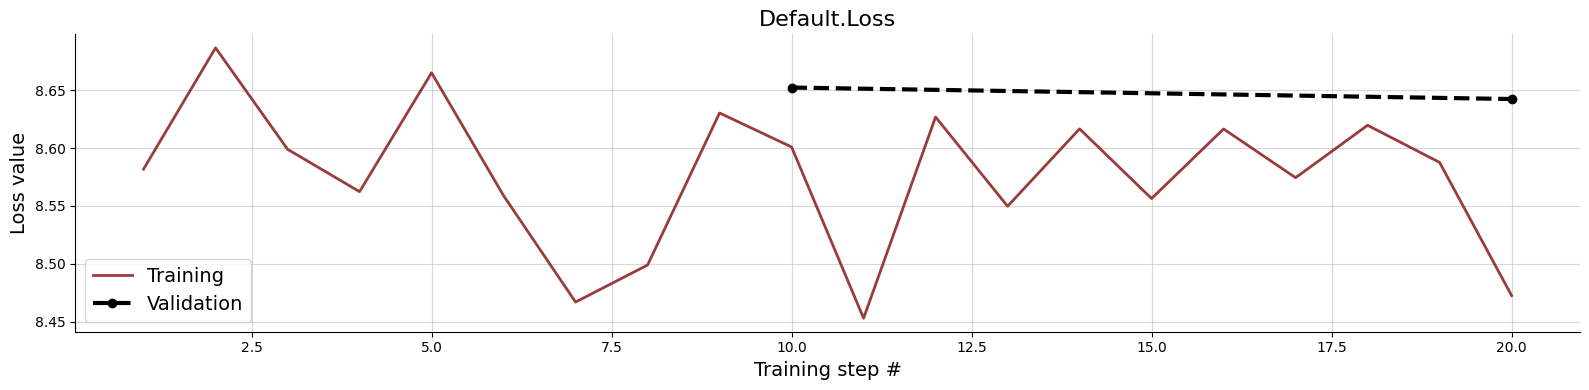

In [44]:
f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation Phase
## Inspecting the Latent Space

In [106]:
#f = trainer.diagnose_latent2d()

# Simulation-Based Calibration - Rank Histograms

In [23]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = ((sim_dict['prior_draws'].astype(np.float32)) - prior_means) / prior_stds
    #params = (params - prior_means) / prior_stds
    
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
        
    out['summary_conditions'] = data[idx_keep]
    out['parameters'] = params[idx_keep]

    
    
    
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    return out


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
from scipy.stats import skew 
from scipy.stats import kurtosis 

# Load your datasets
ldt_session_1_data = pd.read_csv('./############retest_transformed /ldt_session_1_data_transformed.csv')
ldt_session_2_data = pd.read_csv('./############retest_transformed /ldt_session_2_data_transformed.csv')
rmt_session_1_data = pd.read_csv('./############retest_transformed /rmt_session_1_data_transformed.csv')
rmt_session_2_data = pd.read_csv('./############retest_transformed /rmt_session_2_data_transformed.csv')
# Concatenate the values of each parameter across all datasets
alpha_values = pd.concat([ldt_session_1_data['alpha_mean'], ldt_session_2_data['alpha_mean'], 
                          rmt_session_1_data['alpha_mean'], rmt_session_2_data['alpha_mean']])
parameters = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean']
other_params_data = pd.concat([ldt_session_1_data[parameters], ldt_session_2_data[parameters], 
                               rmt_session_1_data[parameters], rmt_session_2_data[parameters]])

# Calculate the overall mean and standard deviation for all parameters
normal_params_stats = other_params_data.describe().loc[['mean', 'std']]

# Calculate skewness for the 'alpha' parameter
alpha_skewness = skew(alpha_values)
alpha_mean = alpha_values.mean()
alpha_std = alpha_values.std()

# Number of samples you want to generate
num_samples = 114

# Generate simulated values for normal parameters
simulated_values = {}
for param in parameters:
    mean, std = normal_params_stats[param]
    simulated_values[param] = np.random.normal(mean, std, num_samples)

# Generate simulated values for the alpha parameter using skewnorm
alpha_simulated_values = skewnorm.rvs(alpha_skewness, loc=alpha_mean, scale=alpha_std, size=num_samples)
simulated_values['alpha'] = alpha_simulated_values

# Output the simulated values (you can also save them to a file or use them directly)
print(simulated_values)


{'v1_mean': array([2.90265345, 3.32162472, 1.42551493, 1.55005734, 2.46353748,
       2.91464057, 0.53289722, 1.94793812, 2.60079439, 2.86630583,
       3.25323553, 3.48035276, 2.89145253, 3.05893525, 2.09538959,
       3.39827916, 2.29063292, 2.83636752, 2.22345426, 2.44137631,
       2.1248431 , 3.27945683, 2.51737363, 3.49626066, 3.87844514,
       3.62844619, 2.74721472, 2.90052632, 1.64903087, 1.4004981 ,
       3.34831118, 3.49514618, 2.50825479, 2.85865419, 2.3035251 ,
       1.82776304, 2.84221278, 2.97315996, 1.76378787, 1.06218754,
       3.51130585, 3.74583419, 3.05116759, 2.57274958, 2.7826146 ,
       3.40553114, 1.62991797, 3.24312392, 2.15739547, 3.18336378,
       2.40782235, 3.2809655 , 3.14378235, 3.0204492 , 3.88106974,
       2.39482146, 1.34916056, 1.75598634, 3.2024606 , 1.96920681,
       1.11507102, 1.39178466, 1.91936005, 3.17205008, 2.54642271,
       2.95319091, 1.87208052, 0.60976151, 1.0977021 , 2.33539654,
       4.07840731, 1.922908  , 3.95336517, 0.65713

In [25]:
alpha_mean,alpha_std,alpha_skewness

(1.818367572147898, 0.14709282131043366, -2.3169006257662565)

In [26]:
from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [27]:
get_truncated_normal(mean=alpha_mean, sd=alpha_std, low=1, upp=2).rvs()


1.7816644234572492

In [29]:
def draw_prior_simulation_study():
    """Generates random draws from the prior."""
    v1 = get_truncated_normal(mean=2.580820, sd= 0.75164, low=0, upp=5).rvs()
#    v1 =np.random.normal(2.580820, 0.75164)

    v2 = get_truncated_normal(mean=-2.167852, sd= 0.850266, low=-5, upp=0).rvs()
#    v2 =np.random.normal(-2.167852, 0.850266)

    #zr =np.random.normal(0.463575, 0.063678)
    zr = get_truncated_normal(mean=0.463575, sd=0.063678, low=0.3, upp=0.7).rvs()

    #a  =np.random.normal(1.244049, 0.318023)
    a = get_truncated_normal(mean=1.244049, sd=0.318023, low=0.6, upp=3.0).rvs()

  #  ndt =np.random.normal(0.498172, 0.076822)
    ndt = get_truncated_normal(mean=0.498172, sd=0.076822, low=0.1, upp=0.7).rvs()

    sndt = get_truncated_normal(mean=0.024505, sd=0.020191, low=0, upp=0.3).rvs()
#    sndt =np.random.normal(0.024505, 0.020191)
    alpha =get_truncated_normal(mean=alpha_mean, sd=alpha_std, low=1, upp=2).rvs()

    #alpha =skewnorm.rvs(alpha_skewness, loc=alpha_mean, scale=alpha_std)

    return np.array([v1,v2,zr,a, ndt,sndt,alpha])

In [30]:
prior_simulation_study = bf.simulation.Prior(prior_fun=draw_prior_simulation_study,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
var_num_obs_simulation_study = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator_simulation_study = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs_simulation_study)
generative_model_simulation_study = bf.simulation.GenerativeModel(prior_simulation_study,simulator_simulation_study,name='v2_equiv')

Performing 2 pilot runs with the v2_equiv model...
Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 2)
No optional prior non-batchable context provided.
No optional prior batchable context provided.
Shape of simulation non-batchable context: (2,)
No optional simulation batchable context provided.


In [31]:
#summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)
#inference_net_simula = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=6)
#amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




In [32]:
generative_model_simulation_study(10)

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[ 3.06980651, -3.2477033 ,  0.37795734,  1.61230895,  0.44721763,
          0.01273344,  1.94648589],
        [ 2.99623862, -2.59721389,  0.48040003,  1.30495722,  0.40276793,
          0.02431553,  1.6581641 ],
        [ 2.71743379, -2.60771439,  0.47502565,  1.31451363,  0.47618518,
          0.04104311,  1.75117682],
        [ 3.22634418, -1.80578585,  0.39212542,  1.07894417,  0.63218658,
          0.03724125,  1.81185322],
        [ 2.99191122, -2.38619505,  0.49216479,  1.55872582,  0.55092335,
          0.02309389,  1.77434271],
        [ 2.63303041, -2.20353051,  0.40410266,  1.57940941,  0.51662691,
          0.01747539,  1.79222958],
        [ 1.9167916 , -1.67955402,  0.47659558,  1.36324506,  0.52059945,
          0.02740408,  1.72952831],
        [ 3.21601903, -1.32805049,  0.38189605,  1.34483287,  0.62363103,
          0.02584856,  1.5396212 ],
        [ 1.4612106 , -2.5898145 

In [17]:
num_test = 1000
num_posterior_draws_recovery = 5000
new_sims = configurator(generative_model_simulation_study(num_test))

NameError: name 'generative_model_simulation_study' is not defined

In [34]:
new_sims['summary_conditions'].shape


(1000, 400, 2)

In [35]:
new_sims['parameters']=new_sims['parameters']*prior_stds+prior_means

In [36]:
new_sims

{'summary_conditions': array([[[ 0.8200796 ,  0.        ],
         [-1.1695393 ,  0.        ],
         [ 0.62522787,  0.        ],
         ...,
         [-1.0602237 ,  1.        ],
         [ 0.6479642 ,  1.        ],
         [-0.6138957 ,  1.        ]],
 
        [[ 0.83628434,  0.        ],
         [ 0.5732405 ,  0.        ],
         [ 0.5758266 ,  0.        ],
         ...,
         [-0.746087  ,  1.        ],
         [-0.62851745,  1.        ],
         [-0.9539117 ,  1.        ]],
 
        [[ 0.80642486,  0.        ],
         [ 1.1359103 ,  0.        ],
         [ 0.6005676 ,  0.        ],
         ...,
         [-0.7094811 ,  1.        ],
         [-0.6939977 ,  1.        ],
         [-0.5648927 ,  1.        ]],
 
        ...,
 
        [[ 0.5547293 ,  0.        ],
         [ 0.6015868 ,  0.        ],
         [ 0.6663919 ,  0.        ],
         ...,
         [-1.1109054 ,  1.        ],
         [-0.56688   ,  1.        ],
         [-0.5471735 ,  1.        ]],
 
       

In [37]:
new_sims['parameters'][:,6]

array([1.76765835, 1.83742607, 1.71261287, 1.92197752, 1.65680158,
       1.90446639, 1.94956517, 1.74146068, 1.99571109, 1.74185777,
       1.83410823, 1.94892085, 1.80394769, 1.80195332, 1.96437848,
       1.84545457, 1.80867922, 1.58166337, 1.73868978, 1.76026893,
       1.70950127, 1.80853713, 1.87668943, 1.72358251, 1.58289015,
       1.51742709, 1.86115634, 1.6836282 , 1.69818556, 1.85858226,
       1.77806628, 1.79689276, 1.95560896, 1.72453237, 1.6177094 ,
       1.90647972, 1.6681782 , 1.94178998, 1.76855218, 1.78460062,
       1.95389712, 1.75206089, 1.69415426, 1.71901429, 1.85368454,
       1.91133857, 1.99159729, 1.81516278, 1.70971394, 1.97752964,
       1.57161522, 1.74989688, 1.64149308, 1.90027082, 1.83443558,
       1.82794464, 1.35633767, 1.81504858, 1.98513627, 1.89922881,
       1.72577679, 1.84226811, 1.73510265, 1.61487448, 1.89288723,
       1.9500854 , 1.84279072, 1.87141323, 1.96927321, 1.84383738,
       1.92690837, 1.77795708, 1.9842279 , 1.78610766, 1.91007

(array([  4.,  10.,  30.,  54.,  88., 150., 181., 215., 144., 124.]),
 array([1.35515308, 1.41944039, 1.48372769, 1.548015  , 1.6123023 ,
        1.67658961, 1.74087691, 1.80516422, 1.86945152, 1.93373883,
        1.99802613]),
 <BarContainer object of 10 artists>)

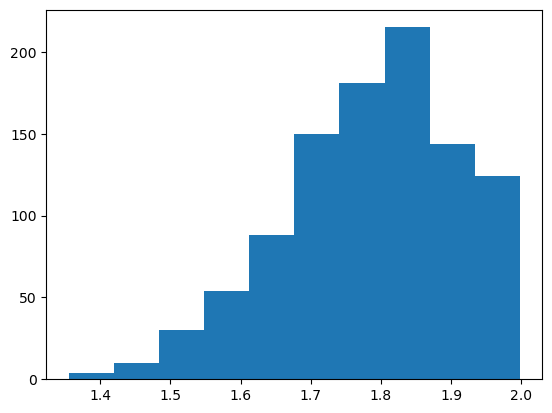

In [38]:
plt.hist(new_sims['parameters'][:,6])

(array([125., 178., 188., 184., 142., 103.,  45.,  23.,   6.,   6.]),
 array([5.61560628e-05, 8.99411757e-03, 1.79320791e-02, 2.68700406e-02,
        3.58080021e-02, 4.47459636e-02, 5.36839251e-02, 6.26218866e-02,
        7.15598481e-02, 8.04978096e-02, 8.94357711e-02]),
 <BarContainer object of 10 artists>)

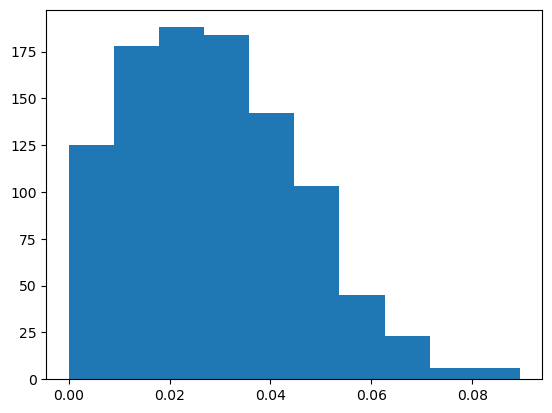

In [39]:
plt.hist(new_sims['parameters'][:,5])

(array([  3.,  24.,  76., 121., 203., 218., 185.,  95.,  60.,  15.]),
 array([0.26546907, 0.30851898, 0.35156889, 0.3946188 , 0.4376687 ,
        0.48071861, 0.52376852, 0.56681843, 0.60986834, 0.65291824,
        0.69596815]),
 <BarContainer object of 10 artists>)

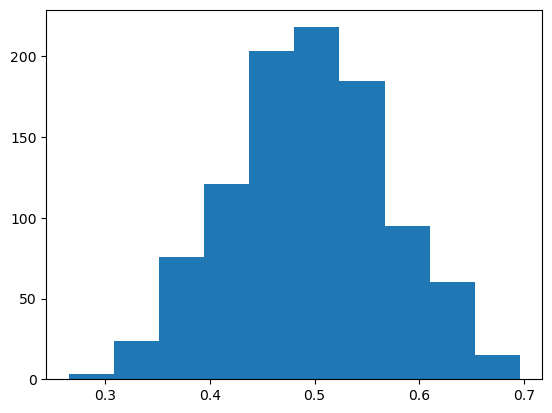

In [40]:
plt.hist(new_sims['parameters'][:,4])

(array([ 36.,  90., 158., 217., 204., 144.,  92.,  39.,  13.,   7.]),
 array([0.60264039, 0.76404278, 0.92544518, 1.08684757, 1.24824996,
        1.40965235, 1.57105474, 1.73245714, 1.89385953, 2.05526192,
        2.21666431]),
 <BarContainer object of 10 artists>)

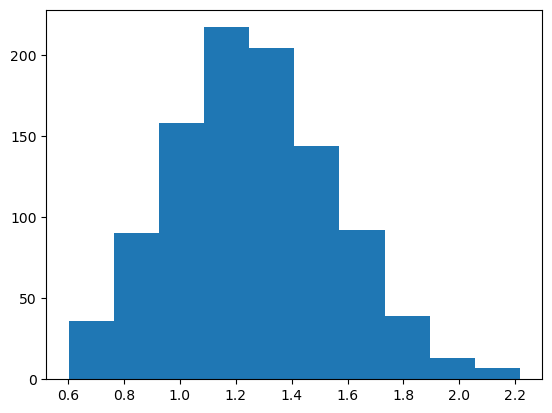

In [41]:
plt.hist(new_sims['parameters'][:,3])

(array([ 29.,  76., 162., 251., 216., 153.,  73.,  32.,   6.,   2.]),
 array([0.30469248, 0.3439462 , 0.38319992, 0.42245364, 0.46170736,
        0.50096108, 0.5402148 , 0.57946852, 0.61872224, 0.65797596,
        0.69722968]),
 <BarContainer object of 10 artists>)

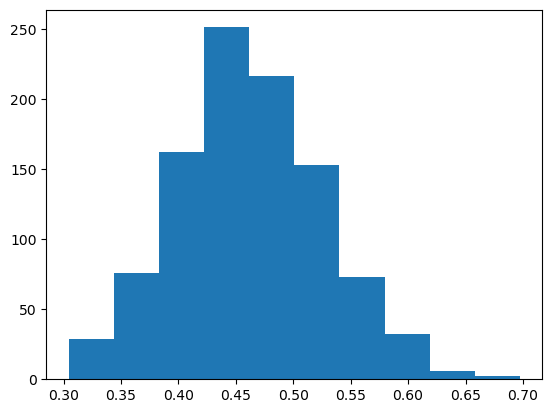

In [42]:
plt.hist(new_sims['parameters'][:,2])

(array([  3.,  15.,  59., 107., 184., 219., 189., 140.,  63.,  21.]),
 array([-4.97524548, -4.4815013 , -3.98775713, -3.49401296, -3.00026879,
        -2.50652462, -2.01278045, -1.51903628, -1.0252921 , -0.53154793,
        -0.03780376]),
 <BarContainer object of 10 artists>)

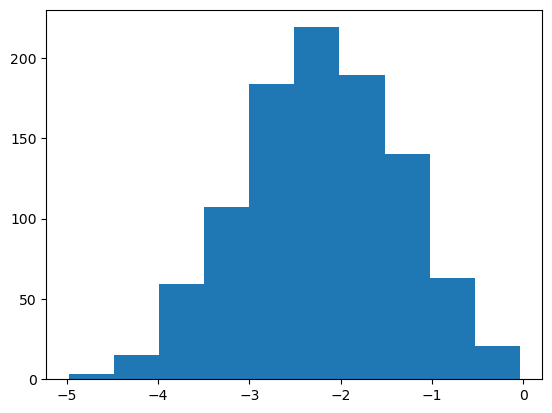

In [43]:
plt.hist(new_sims['parameters'][:,1])

(array([ 13.,  50., 109., 168., 223., 187., 144.,  76.,  21.,   9.]),
 array([0.59574378, 1.01494151, 1.43413925, 1.85333699, 2.27253473,
        2.69173247, 3.1109302 , 3.53012794, 3.94932568, 4.36852342,
        4.78772116]),
 <BarContainer object of 10 artists>)

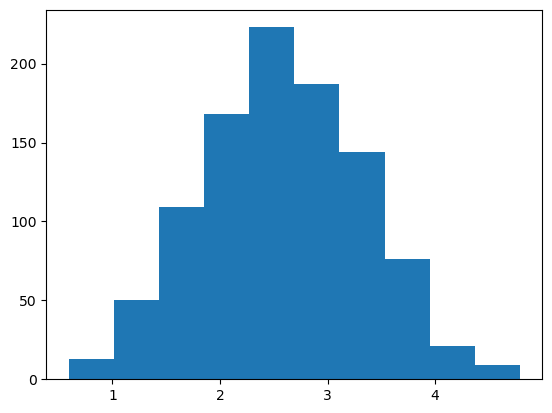

In [44]:
plt.hist(new_sims['parameters'][:,0])

In [45]:
np.corrcoef(new_sims['parameters'][:,6],new_sims['parameters'][:,3])

array([[ 1.        , -0.00882432],
       [-0.00882432,  1.        ]])

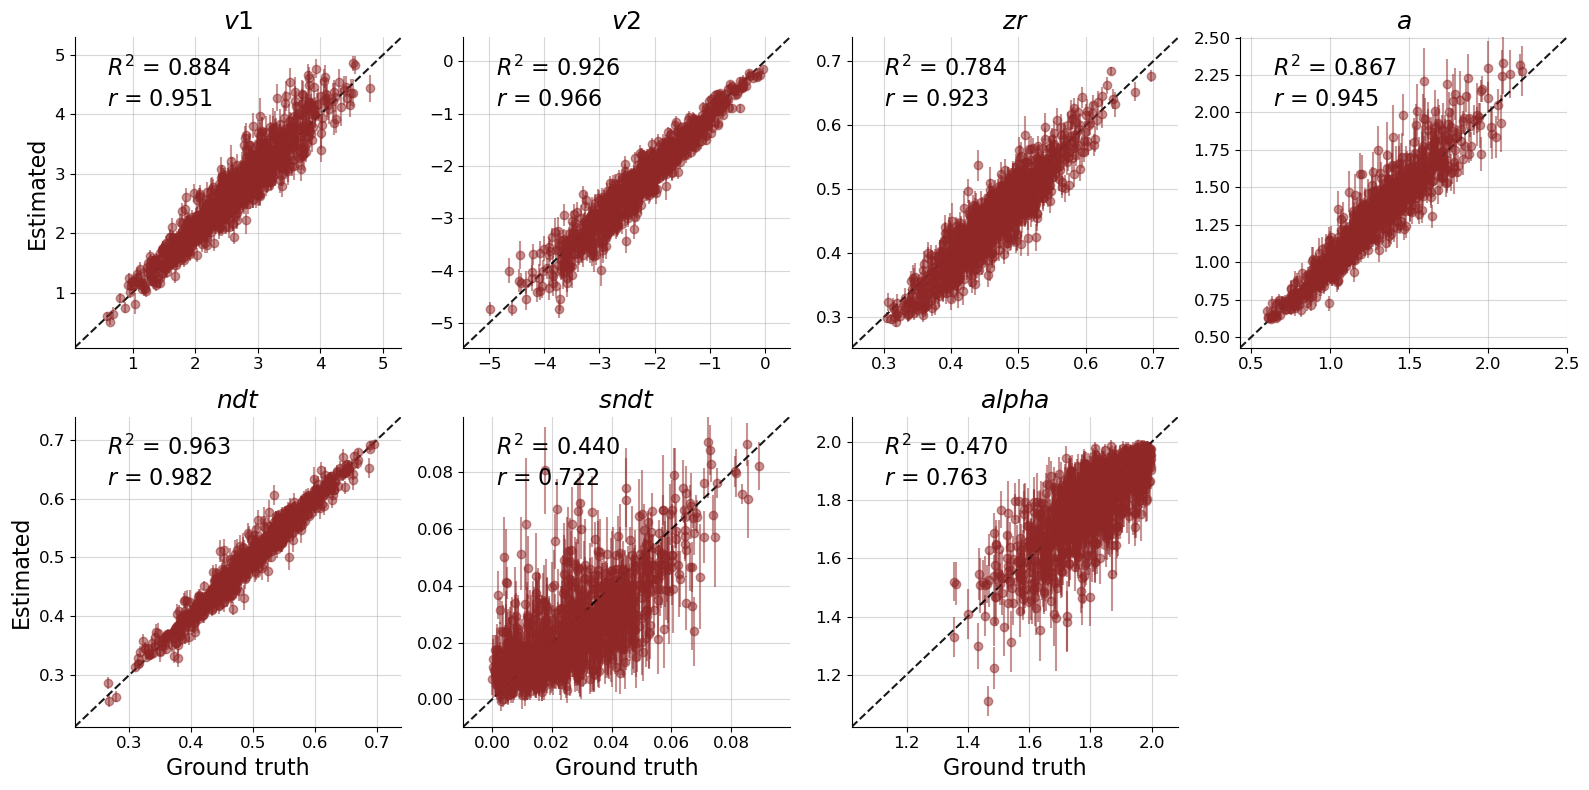

In [51]:
posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
posterior_draws = prior_means + posterior_draws * prior_stds

fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
plt.savefig('./figures_retest_config/recovery_not_normalized.png')


In [47]:
posterior_draws.shape

(1000, 5000, 7)

In [48]:
posterior_draws[:,:,6].shape

(1000, 5000)

In [49]:
posterior_draws[:,:,6].mean()

1.7651194983075797

In [50]:
alpha_mean_list= [] 
a_mean_list= []
for i in range(1000): 
    alpha_mean_list.append(posterior_draws[i,:,6].mean())
    a_mean_list.append(posterior_draws[i,:,3].mean())

np.corrcoef(alpha_mean_list,a_mean_list)

array([[1.        , 0.02304366],
       [0.02304366, 1.        ]])

In [59]:
#plt.savefig('./figures_retest_config/recovery_not_normalized.png')


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

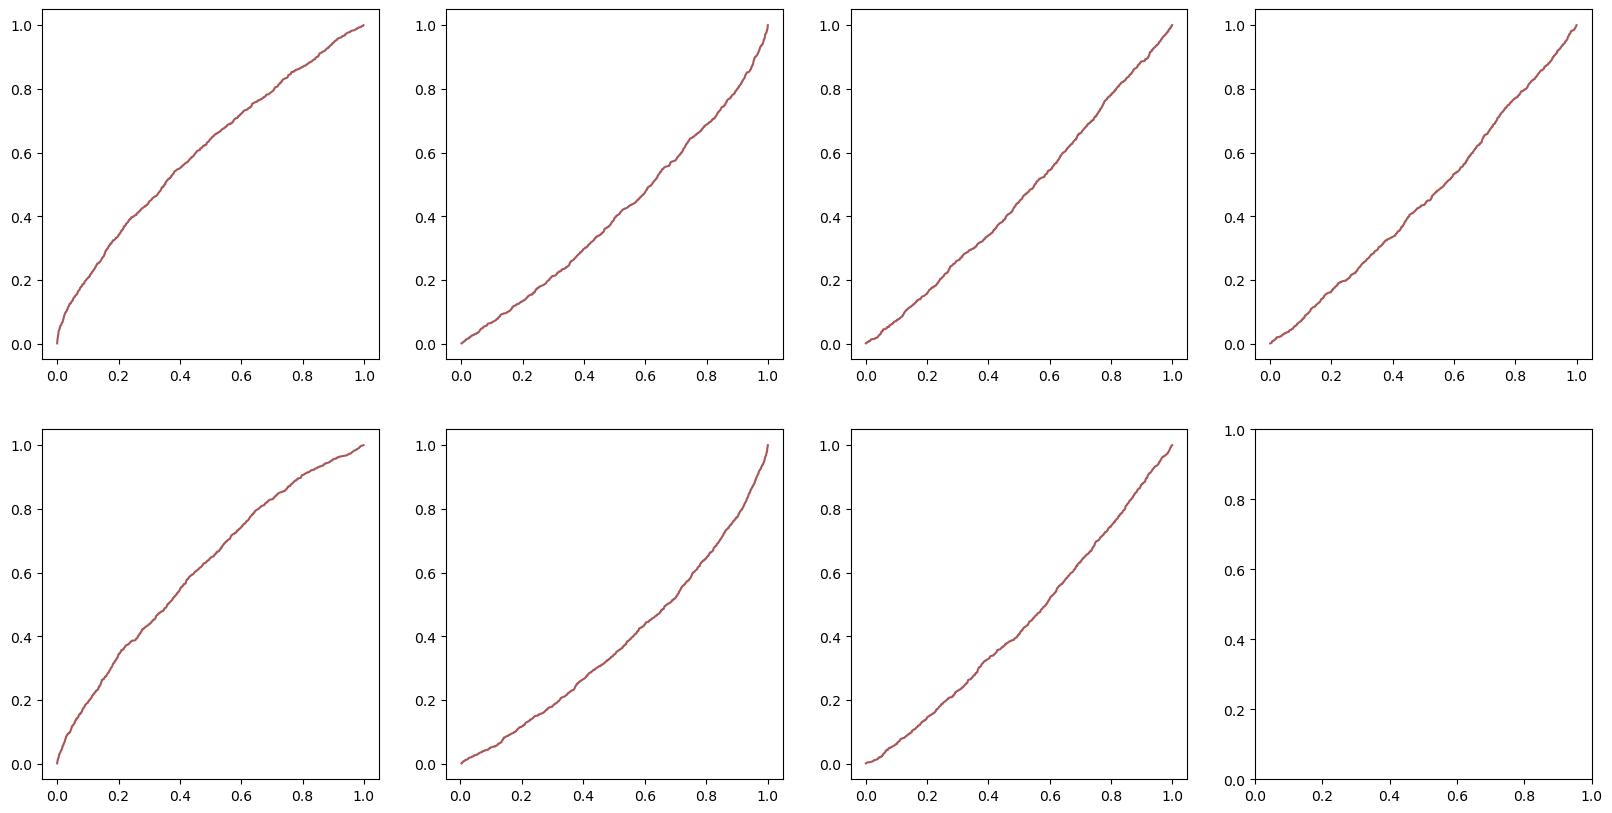

In [60]:
#posterior_draws = amortizer.sample(new_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'], stacked=True, 
                       difference=True, legend_fontsize=12, fig_size=(10, 8))

In [ ]:
posterior_draws = amortizer.sample(new_sims, n_samples=50)
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, new_sims['parameters'], num_bins=10,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

In [ ]:
#posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
# Michael Nunez's recovery function
def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)


# Plot the results
fig=plt.figure(figsize=(15,8), tight_layout=True)

columns = 3
rows = 3
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
for i in range(len(param_names)):
    
    fig.add_subplot(rows, columns, i+1)
    recovery(posterior_draws[:, :, i].reshape(num_test, num_posterior_draws_recovery, 1), new_sims['parameters'][:, i].squeeze())
    plt.xlabel('Grand truth', fontsize=16)
    plt.ylabel('Posterior', fontsize=16)
    plt.title(param_names[i], fontsize=16)
    if i==0:
        plt.legend(['99% CI','95% CI','Median', 'Mean'], fontsize=11, loc = 'upper left')


plt.savefig('./figures_retest_config/Blue_recovery.png')


In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
def compute_performance_metrics(model, n_points_grid, param_names, 
                                 n_sim=20, n_test=300, n_samples=2000, transform=None):
    """
    Compute metrics for different numbers of datapoints.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    param_names     : list of strings -- the names of the parameters
    simulate_fun    : callable -- the simulate function
    n_test          : number of test datasets
    n_samples       : number of samples from the approximate posterior
    transform       : callable ot None -- a function to transform X and theta, if given
    ----------

    Returns:
    metrics : dict -- a dictionary with the metrics
    """

    metrics = {
        'rmse':  {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'nrmse': {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'r2':    {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'std':   {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names}
    }
    
    with tqdm(total=n_points_grid.shape[0]) as p_bar:
        for n, n_points in enumerate(n_points_grid):
            def prior_N(n_min=n_points, n_max=n_points):
                return np.random.randint(n_min, n_max+1)
            p_bar.set_postfix_str("Simulating with N={}".format(n_points))
            for si in range(n_sim):
                
                # Simulate data 
                prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
                var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
                simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
                generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')
                
                x = configurator(generative_model(n_test))
                theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']
                
               # X_test_s, theta_test_s = simulate_fun(n_test, n_points=n_points)
               # if transform is not None:
               #     X_test_s, theta_test_s = transform(X_test_s, theta_test_s)
               # theta_test_s = theta_test_s.numpy()

                # Sample from posterior and compute mean and variance
                posterior_draws = model.sample(x, n_samples=n_samples)
                theta_test_hat = posterior_draws.mean(1)
                theta_test_std = posterior_draws.std(axis=1, ddof=1)

                
                #theta_samples = model.sample(X_test_s, n_samples=n_samples, to_numpy=True)
                #theta_test_hat = theta_samples.mean(0)
                #theta_test_std = theta_samples.std(axis=0, ddof=1)

                # --- Plot true vs estimated posterior means on a single row --- #
                for k, name in enumerate(param_names):

                    # Compute NRMSE
                    rmse = np.sqrt(np.mean( (theta_test_hat[:, k] - theta_test_s[:, k])**2 ))
                    nrmse = rmse / (theta_test_s[:, k].max() - theta_test_s[:, k].min())

                    # Compute R2
                    r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

                    # Extract mean posterior std
                    std = np.mean(theta_test_std[:, k])

                    # Add to dict
                    metrics['rmse'][name][n, si] = rmse
                    metrics['nrmse'][name][n, si] = nrmse
                    metrics['r2'][name][n, si] = r2
                    metrics['std'][name][n, si]  = std
            p_bar.update(1)
        return metrics


In [ ]:
n_points_grid=np.arange(100, 1001, 10)

metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    #simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000)
                    #transform=transform)

In [ ]:
def plot_performance_metrics(metrics, n_points_grid, param_names, figsize=(12, 4), show=True, 
                             xlabel=r'$n$', filename=None, legend_loc=None, std_ci=2, font_size=12):
    
    """Plots specified metrics over ns."""

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Initialize figure
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    for i, metric in enumerate(['nrmse', 'r2']):
        for p in param_names:

            metric_mean = metrics[metric][p].mean(axis=1)
            metric_std = metrics[metric][p].std(axis=1, ddof=1)

            axarr[i].plot(n_points_grid, metric_mean, label=p, lw=2)
            axarr[i].fill_between(n_points_grid, 
                            metric_mean-std_ci*metric_std, 
                            metric_mean+std_ci*metric_std, 
                            interpolate=True, alpha=0.2)

        if metric == 'nrmse':
            axarr[i].set_ylabel('NRMSE')
        elif metric == 'r2':
            axarr[i].set_ylabel(r'$R^{2}$')
        axarr[i].set_xlabel(xlabel)

        axarr[i].spines['right'].set_visible(False)
        axarr[i].spines['top'].set_visible(False)
        if legend_loc is not None:
            axarr[i].legend(loc=legend_loc[i], fontsize=10)
        else:
            axarr[i].legend(fontsize=12)

    f.tight_layout()
    
    if show:
        plt.show()
    
    if filename is not None:
        f.savefig("figures/{}_metrics.png".format(filename), dpi=600, bbox_inches='tight')



In [ ]:
plot_performance_metrics(metrics, 
                         n_points_grid, 
                         param_names, 
                         legend_loc=['upper right', 'lower right'],
                         xlabel=r'Number of trials ($N$)', 
                         figsize=(12, 6),
                         filename='Levy_Metrics')

In [ ]:
x = configurator(generative_model(32))
theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']

In [ ]:
X_test_s.shape

In [ ]:
n_samples  = 1000
posterior_draws = amortizer.sample(x, n_samples=num_posterior_draws_recovery)
#theta_samples = amortizer.sample(X_test_s, n_samples=n_samples)

In [ ]:
posterior_draws.shape

In [ ]:
theta_test_hat = posterior_draws.mean(1)
theta_test_std = posterior_draws.std(axis=1, ddof=1)


In [ ]:
theta_test_hat.shape

In [ ]:
theta_test_hat

In [ ]:
theta_test_std.shape

In [ ]:
theta_test_std

In [ ]:
r2 = r2_score(theta_test_s[:,1], theta_test_hat[:,1])

In [ ]:
r2 = r2_score(theta_test_s[:,2], theta_test_hat[:,2])
r2

In [ ]:
r2

In [ ]:
r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

In [ ]:
theta_test_s.shape

In [ ]:
n_points_grid=np.arange(100, 121, 10)
for n, n_points in enumerate(n_points_grid):
    print (n_points)

In [ ]:
n_points_grid=np.arange(100, 121, 10)
metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000
                    )

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp,param_names=prior.param_names)

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp, prior=prior)

In [ ]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)
    
    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color=color, alpha=0.1, label='95% CI')
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
    return f

In [ ]:
f = plot_ppc(config, post_samples)
